# Walmart Sales Forecast
Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

Uploading dataset file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Walmart Store Sales.csv to Walmart Store Sales.csv


Loading the dataset into dataframe

In [ ]:
df = pd.read_csv('Walmart Store Sales.csv')

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


#EDA
Checking shape of data and missing values

In [ ]:
print("Shape of dataset:", df.shape)
print("\nDatatypes and missing values:")
print (df.info())
print("\nSummary Statistics:")
print(df.describe())

Shape of dataset: (421570, 5)

Datatypes and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

Summary Statistics:
               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.0

In [ ]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


Converting Date into datetime format

In [ ]:
df["Date"]=pd.to_datetime(df["Date"])

Segregating Unique Stores and Departments

In [ ]:
print("\nUnique Stores:", df['Store'].nunique)
print("Unique Departments", df['Dept'].nunique)


Unique Stores: <bound method IndexOpsMixin.nunique of 0          1
1          1
2          1
3          1
4          1
          ..
421565    45
421566    45
421567    45
421568    45
421569    45
Name: Store, Length: 421570, dtype: int64>
Unique Departments <bound method IndexOpsMixin.nunique of 0          1
1          1
2          1
3          1
4          1
          ..
421565    98
421566    98
421567    98
421568    98
421569    98
Name: Dept, Length: 421570, dtype: int64>


#Ploting Stats
Total Weekly Sales Overtime

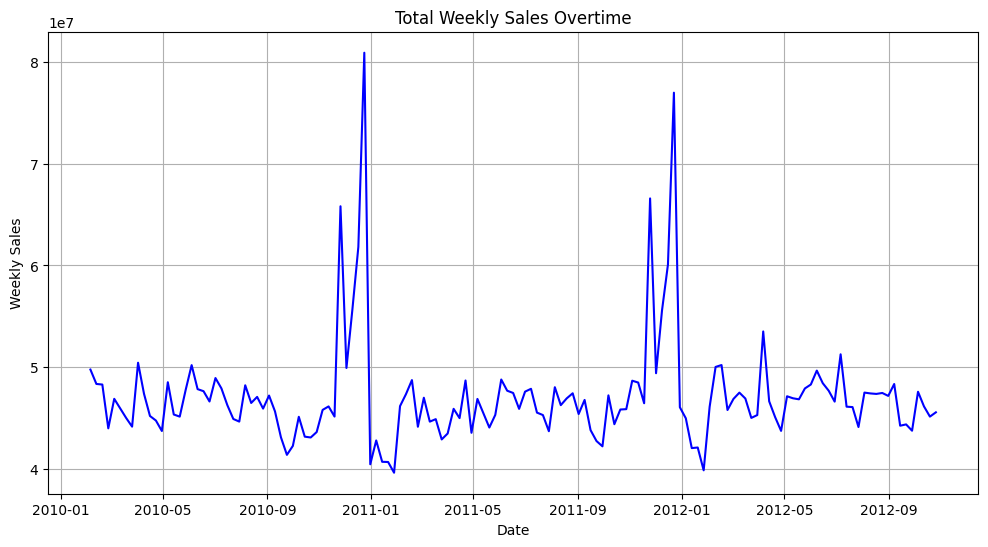

In [ ]:
sales_by_date = df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_date.index, sales_by_date.values, color='blue')
plt.title('Total Weekly Sales Overtime')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.tight_layout
plt.show()

Boxplot of Weekly Sales by Holiday

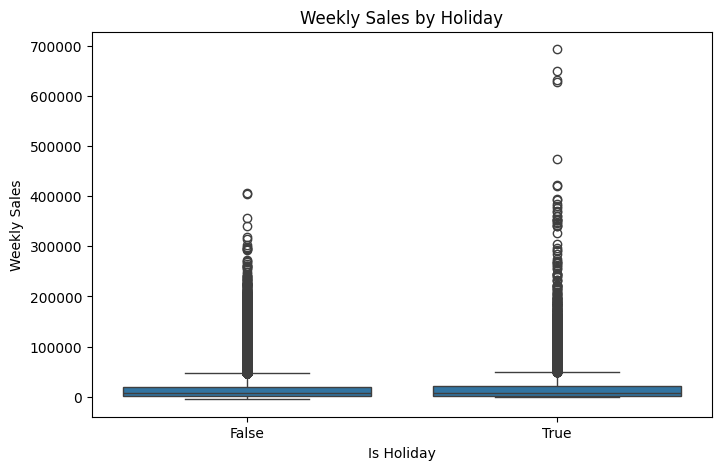

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=df)
plt.title('Weekly Sales by Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales')
plt.tight_layout
plt.show()

Barplot of Average Weekly Sales by Store

/tmp/ipython-input-11-3376245050.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sales_by_store.index, y=avg_sales_by_store.values, palette='viridis')


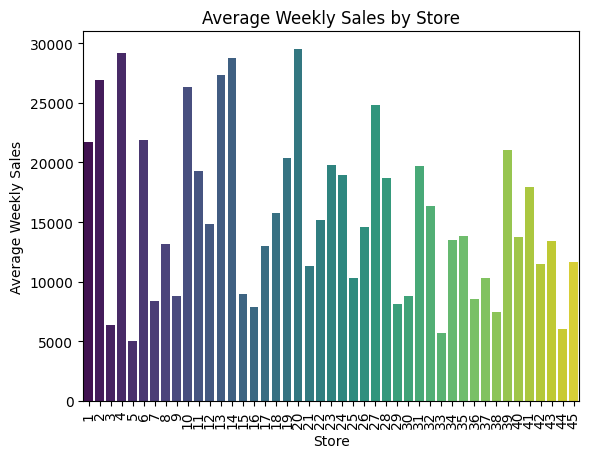

In [ ]:
avg_sales_by_store = df.groupby('Store') ['Weekly_Sales'].mean().sort_values(ascending=False)

sns.barplot(x=avg_sales_by_store.index, y=avg_sales_by_store.values, palette='viridis')
plt.title('Average Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=90)
plt.tight_layout
plt.show()

Date conversion into useable data

In [ ]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

df['IsHoliday'] = df['IsHoliday'].astype(int)

Data Pre-processing for Random Forest

In [ ]:
features_rf = ['Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'IsHoliday']
X_rf = df[features_rf]
y_rf = df['Weekly_Sales']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, shuffle=False)

from sklearn.preprocessing import StandardScaler
scaler_rf = StandardScaler()
X_train_rf_scaled = scaler_rf.fit_transform(X_train_rf)
X_test_rf_scaled = scaler_rf.transform(X_test_rf)

Data Pre-processing for LSTM

In [ ]:
features_lstm = ['Weekly_Sales', 'IsHoliday', 'Month', 'DayOfWeek']
df_lstm = df[features_lstm].copy()

from sklearn.preprocessing import MinMaxScaler
scaler_lstm = MinMaxScaler()
df_lstm_scaled = scaler_lstm.fit_transform(df_lstm)

def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

sequence_length = 10
X_lstm, y_lstm = create_sequences(df_lstm_scaled, sequence_length)

split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

Random Forest Training and Evaluation

📊 Random Forest Performance:
RMSE: 19435.53
MAE: 14746.82


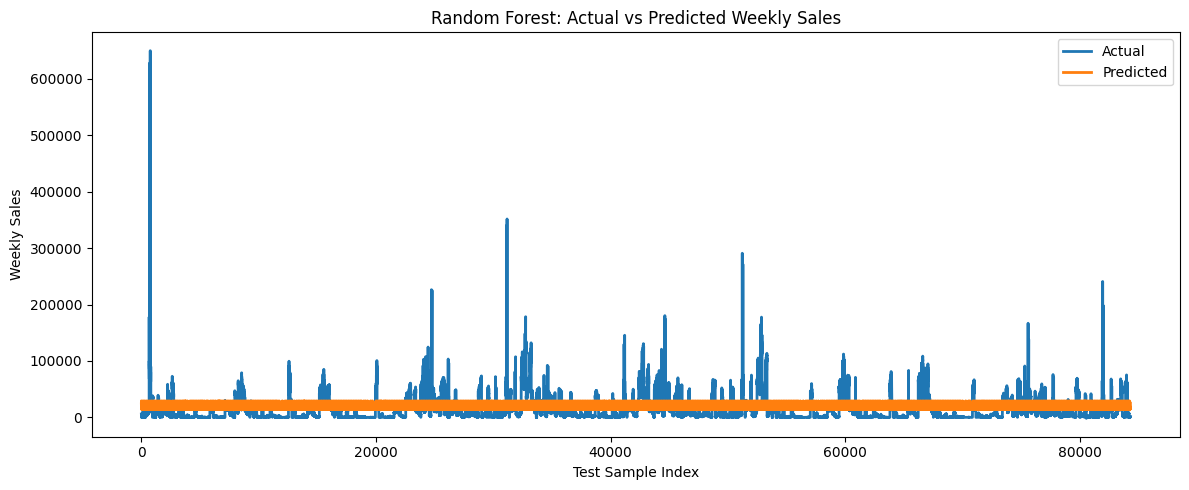

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_rf_scaled, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf_scaled)

mse = mean_squared_error(y_test_rf, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rf, y_pred_rf)

print("📊 Random Forest Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(y_test_rf.values, label='Actual', linewidth=2)
plt.plot(y_pred_rf, label='Predicted', linewidth=2)
plt.title("Random Forest: Actual vs Predicted Weekly Sales")
plt.xlabel("Test Sample Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

LSTM Training and Evaluation

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/6
16863/16863 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - loss: 1.9246e-04 - val_loss: 6.7788e-05
Epoch 2/6
16863/16863 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - loss: 1.1471e-04 - val_loss: 5.6458e-05
Epoch 3/6
16863/16863 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 9.8357e-05 - val_loss: 8.2972e-05
Epoch 4/6
16863/16863 ━━━━━━━━━━━━━━━━━━━━ 143s 5ms/step - loss: 9.7584e-05 - val_loss: 4.8609e-05
Epoch 5/6
16863/16863 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - loss: 9.0449e-05 - val_loss: 4.6296e-05
Epoch 6/6
16863/16863 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - loss: 8.5114e-05 - val_loss: 5.5021e-05


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
LSTM Performance:
RMSE: 4904.50
MAE: 1552.00


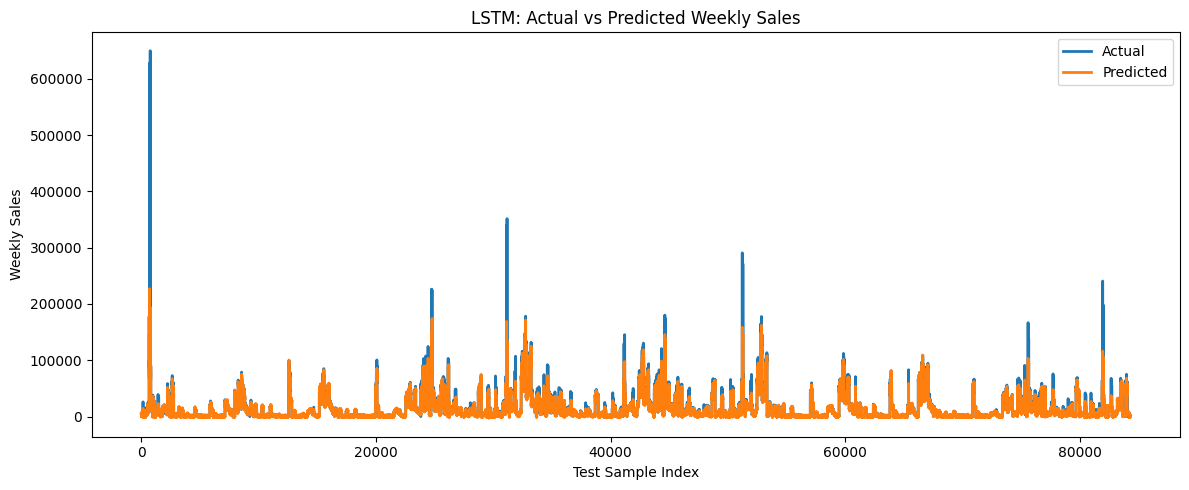

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm)

y_pred_lstm_inv = scaler_lstm.inverse_transform(
    np.concatenate([y_pred_lstm, np.zeros((len(y_pred_lstm), df_lstm.shape[1]-1))], axis=1)
)[:, 0]
y_test_lstm_inv = scaler_lstm.inverse_transform(
    np.concatenate([y_test_lstm.reshape(-1, 1), np.zeros((len(y_test_lstm), df_lstm.shape[1]-1))], axis=1)
)[:, 0]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_lstm_inv, y_pred_lstm_inv)
r2 = r2_score(y_test_lstm_inv, y_pred_lstm_inv)

print("LSTM Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(y_test_lstm_inv, label='Actual', linewidth=2)
plt.plot(y_pred_lstm_inv, label='Predicted', linewidth=2)
plt.title("LSTM: Actual vs Predicted Weekly Sales")
plt.xlabel("Test Sample Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

Saving LSTM as it had better results

In [ ]:
import joblib
joblib.dump(scaler_lstm, 'scaler_lstm.pkl')
lstm_model.save('lstm_sales_model.h5')

NameError: name 'scaler_lstm' is not defined